<a href="https://colab.research.google.com/github/sdikici/Time_Series_Experiments/blob/main/DeepAR_experiment_with_regressors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d albertovidalrod/electricity-consumption-uk-20092022

 88% 17.0M/19.2M [00:00<00:00, 62.2MB/s]
100% 19.2M/19.2M [00:00<00:00, 65.5MB/s]


In [6]:
! unzip electricity-consumption-uk-20092022.zip

Archive:  electricity-consumption-uk-20092022.zip
  inflating: historic_demand_2009_2024.csv  
  inflating: historic_demand_2009_2024_noNaN.csv  
  inflating: historic_demand_year_2009.csv  
  inflating: historic_demand_year_2010.csv  
  inflating: historic_demand_year_2011.csv  
  inflating: historic_demand_year_2012.csv  
  inflating: historic_demand_year_2013.csv  
  inflating: historic_demand_year_2014.csv  
  inflating: historic_demand_year_2015.csv  
  inflating: historic_demand_year_2016.csv  
  inflating: historic_demand_year_2017.csv  
  inflating: historic_demand_year_2018.csv  
  inflating: historic_demand_year_2019.csv  
  inflating: historic_demand_year_2020.csv  
  inflating: historic_demand_year_2021.csv  
  inflating: historic_demand_year_2022.csv  
  inflating: historic_demand_year_2023.csv  
  inflating: historic_demand_year_2024.csv  


In [7]:
!kaggle datasets download -d sercandikici/london-weather-database-from-2009-to-2024

  0% 0.00/301k [00:00<?, ?B/s]
100% 301k/301k [00:00<00:00, 81.9MB/s]


In [8]:
! unzip london-weather-database-from-2009-to-2024.zip

Archive:  london-weather-database-from-2009-to-2024.zip
  inflating: London_2009_to_2024_forecast.csv  


In [9]:
!pip install gluonts
!pip install "gluonts[torch]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 41.4 MB/s eta 0:00:00


In [10]:
import numpy as np
np.bool = np.bool_

In [11]:
pip install mxnet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 8.4 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [12]:
pip install mxnet --upgrade

In [69]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import gluon
import json

In [70]:
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import Evaluator

import torch
from gluonts.mx import DeepAREstimator
from gluonts.mx.trainer import Trainer

This is an experiment, I am going to use 3 years of data 2009,2010,2011


In [71]:
df_raw = pd.read_csv("historic_demand_2009_2024_noNaN.csv")
df_raw.head()

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
0,2009-01-01 00:00:00,1,0:00:00,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1
1,2009-01-01 00:30:00,2,0:30:00,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1
2,2009-01-01 01:00:00,3,1:00:00,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1
3,2009-01-01 01:30:00,4,1:30:00,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1
4,2009-01-01 02:00:00,5,2:00:00,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1


In [72]:
df_weather = pd.read_csv("London_2009_to_2024_forecast.csv")
df_weather.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,London,2009-01-01,2.7,0.0,1.2,0.6,-3.0,-1.0,-1.2,84.0,...,NaN,NaN,NaN,2009-01-01T08:06:15,2009-01-01T16:02:16,0.17,Overcast,Cloudy skies throughout the day.,cloudy,"03769099999,03660099999,03672099999,0378109999..."
1,London,2009-01-02,4.6,-0.6,2.1,1.3,-3.6,-0.6,-0.5,83.4,...,NaN,NaN,NaN,2009-01-02T08:06:07,2009-01-02T16:03:21,0.20,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"03769099999,03660099999,03672099999,0378109999..."
2,London,2009-01-03,3.0,-4.9,-1.7,2.2,-7.1,-3.0,-5.2,78.3,...,NaN,NaN,NaN,2009-01-03T08:05:55,2009-01-03T16:04:29,0.24,Clear,Clear conditions throughout the day.,clear-day,"03769099999,03660099999,03672099999,0378109999..."
3,London,2009-01-04,0.1,-5.8,-2.6,-2.5,-8.9,-4.7,-4.5,87.0,...,NaN,NaN,NaN,2009-01-04T08:05:40,2009-01-04T16:05:39,0.25,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"03769099999,03660099999,03672099999,0378109999..."
4,London,2009-01-05,1.8,-2.0,0.0,-2.7,-6.8,-4.2,-2.8,82.3,...,NaN,NaN,NaN,2009-01-05T08:05:22,2009-01-05T16:06:52,0.31,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with afternoo...,rain,"03769099999,03660099999,03672099999,0378109999..."


In [73]:
df3_year = df_raw[["settlement_date","tsd"]]
df3_year = df3_year[(df3_year["settlement_date"] >= "2009-01-01 00:00:00")&(df3_year["settlement_date"] <= "2011-12-31 23:30:00")]
df3_year

,settlement_date,tsd
0,2009-01-01 00:00:00,38704
1,2009-01-01 00:30:00,38964
2,2009-01-01 01:00:00,38651
3,2009-01-01 01:30:00,37775
4,2009-01-01 02:00:00,37298
...,...,...
52261,2011-12-31 21:30:00,31982
52262,2011-12-31 22:00:00,31145
52263,2011-12-31 22:30:00,30803
52264,2011-12-31 23:00:00,30441


In [74]:
df3_year['settlement_date'] = pd.to_datetime(df3_year['settlement_date'])
df3_year['settlement_date'] = df3_year['settlement_date'].dt.floor('D')
df3_year

,settlement_date,tsd
0,2009-01-01,38704
1,2009-01-01,38964
2,2009-01-01,38651
3,2009-01-01,37775
4,2009-01-01,37298
...,...,...
52261,2011-12-31,31982
52262,2011-12-31,31145
52263,2011-12-31,30803
52264,2011-12-31,30441


In [75]:
daily = df3_year.groupby('settlement_date').agg({'tsd': 'mean'}).reset_index()
daily

,settlement_date,tsd
0,2009-01-01,38528.395833
1,2009-01-02,41133.458333
2,2009-01-03,40667.791667
3,2009-01-04,41013.958333
4,2009-01-05,47322.312500
...,...,...
1084,2011-12-27,33447.875000
1085,2011-12-28,35252.062500
1086,2011-12-29,36492.541667
1087,2011-12-30,37148.395833


In [76]:
df = daily.copy()
df

,settlement_date,tsd
0,2009-01-01,38528.395833
1,2009-01-02,41133.458333
2,2009-01-03,40667.791667
3,2009-01-04,41013.958333
4,2009-01-05,47322.312500
...,...,...
1084,2011-12-27,33447.875000
1085,2011-12-28,35252.062500
1086,2011-12-29,36492.541667
1087,2011-12-30,37148.395833


In [77]:
df = df.set_index("settlement_date")
df

,tsd
settlement_date,
2009-01-01,38528.395833
2009-01-02,41133.458333
2009-01-03,40667.791667
2009-01-04,41013.958333
2009-01-05,47322.312500
...,...
2011-12-27,33447.875000
2011-12-28,35252.062500
2011-12-29,36492.541667


In [78]:
split_date= "2011-09-01"

train_data = df[df.index < split_date]
test_data = df[df.index >= split_date]
print(train_data.shape)
print(test_data.shape)

(967, 1)
(122, 1)


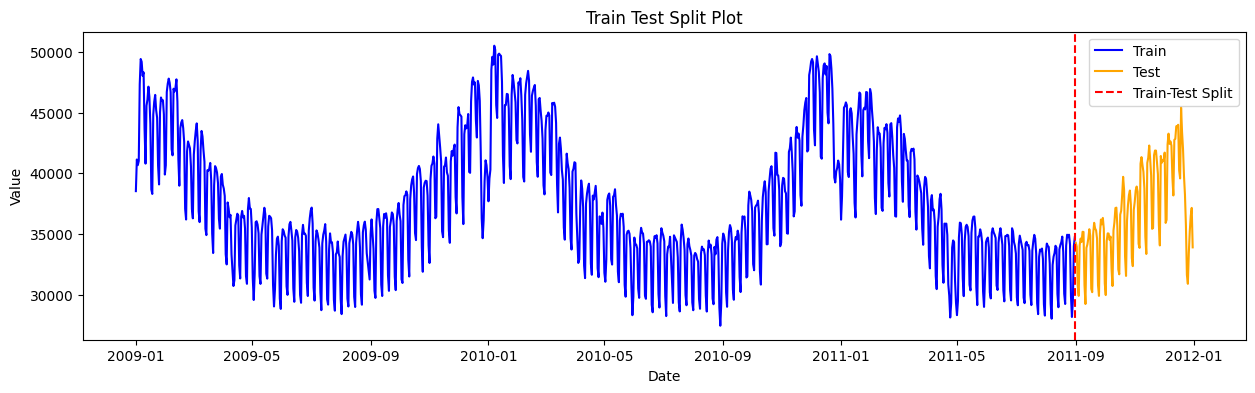

In [79]:
plt.figure(figsize=(15,4))
plt.plot(train_data.index,train_data["tsd"],color="blue", label="Train")
plt.plot(test_data.index,test_data["tsd"], color="orange", label="Test")
plt.axvline(train_data.index[-1], color="red", linestyle="--", label="Train-Test Split")

plt.title('Train Test Split Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [80]:
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import Evaluator

define parameters

In [81]:
freq = "D"
prediction_length = 30
num_layers = 4
num_cells = 64
epochs = 8
context_length = 365

In [82]:
estimator = DeepAREstimator (freq=freq,
                             context_length=context_length, #how much previous observation we need to take to predict future events
                             prediction_length=prediction_length,
                             num_layers=num_layers,
                             num_cells=num_cells,
                             trainer= Trainer(epochs=epochs))

In [83]:
train_ds = ListDataset(
    [{"start":train_data.index[0],
      "target":train_data.tsd}],
    freq=freq
)


test_ds = ListDataset(
    [{"start":test_data.index[0],
      "target":test_data.tsd}],
    freq=freq
)

In [84]:
predictor_1 = estimator.train(training_data=train_ds) #predicting 30 days

100%|██████████| 50/50 [01:36<00:00,  1.92s/it, epoch=8/8, avg_epoch_loss=8.74]


In [85]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset = test_ds,
    predictor=predictor_1,
    num_samples=100
)

In [86]:
forecasts = list(forecast_it)
tss = list(ts_it)

from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics_1, item_metrics_1 = evaluator(iter(tss), iter(forecasts))

Running evaluation: 1it [00:00,  8.95it/s]


In [87]:
agg_metrics_1

{'MSE': 13988651.733333332,
 'abs_error': 97641.4375,
 'abs_target_sum': 1184883.75,
 'abs_target_mean': 39496.125,
 'seasonal_error': 1861.981456043956,
 'MASE': 1.7479844242103444,
 'MAPE': 0.08257463773091635,
 'sMAPE': 0.084877610206604,
 'MSIS': 17.38854365506044,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 41421.57968750001,
 'Coverage[0.1]': 0.1,
 'QuantileLoss[0.5]': 97641.44140625,
 'Coverage[0.5]': 0.16666666666666666,
 'QuantileLoss[0.9]': 67027.517578125,
 'Coverage[0.9]': 0.36666666666666664,
 'RMSE': 3740.1406034176484,
 'NRMSE': 0.0946963937200839,
 'ND': 0.08240592167797052,
 'wQuantileLoss[0.1]': 0.03495834902580106,
 'wQuantileLoss[0.5]': 0.08240592497470743,
 'wQuantileLoss[0.9]': 0.056568855449427004,
 'mean_absolute_QuantileLoss': 68696.84622395835,
 'mean_wQuantileLoss': 0.057977709816645163,
 'MAE_Coverage': 0.3111111111111111,
 'OWA': nan}

In [88]:
mape_1 = round(agg_metrics_1['MAPE'],3)
smape_1 = round(agg_metrics_1['sMAPE'],3)
print(f"MAPE: {mape_1}")
print(f"sMAPE: {smape_1}")

MAPE: 0.083
sMAPE: 0.085


In [89]:
forecasts[0]

gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[37272.375, 33492.633, 33078.93 , ..., 38515.53 , 35974.36 ,
        32443.992],
       [41474.734, 36218.574, 32026.004, ..., 38524.426, 40070.57 ,
        35605.137],
       [39312.19 , 35437.81 , 34336.38 , ..., 40562.484, 38739.36 ,
        32416.316],
       ...,
       [40539.773, 35084.53 , 35084.52 , ..., 37488.297, 37432.945,
        29677.848],
       [40676.383, 33791.875, 33442.094, ..., 36801.97 , 36214.07 ,
        26610.312],
       [39524.16 , 35648.72 , 32245.771, ..., 35546.977, 37955.4  ,
        30201.64 ]], dtype=float32), start_date=Period('2011-12-02', 'D'))

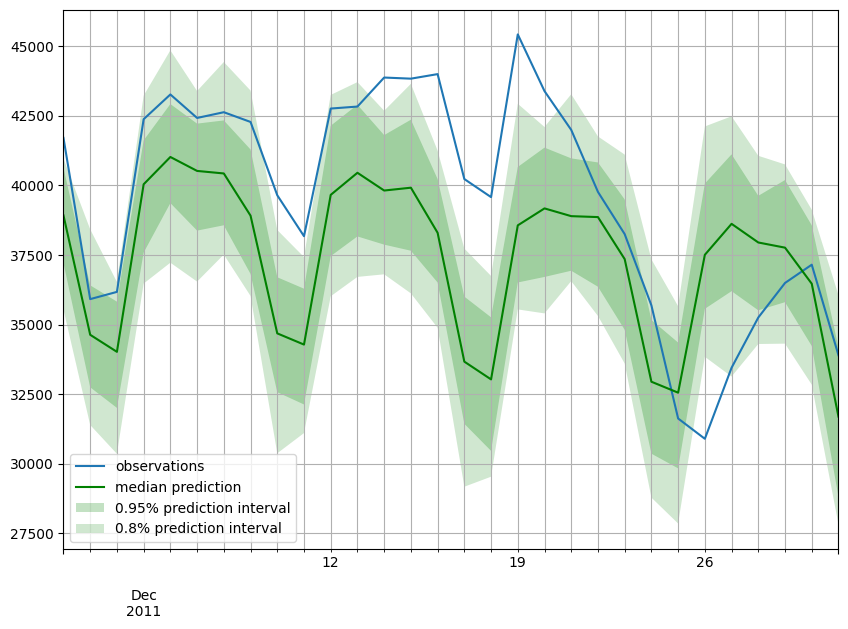

In [90]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = prediction_length
    prediction_intervals = (0.8, 0.95)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)
    forecast_entry.plot(intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="lower left")
    plt.show()


plot_prob_forecasts(tss[0], forecasts[0])

adding one regressor, just holiday as categorical value

With regressors , first with holiday

In [91]:
df3_year_w_holiday = df_raw[["settlement_date","tsd","is_holiday"]]
df3_year_w_holiday = df3_year_w_holiday[(df3_year_w_holiday["settlement_date"] >= "2009-01-01 00:00:00")&(df3_year_w_holiday["settlement_date"] <= "2011-12-31 23:30:00")]
df3_year_w_holiday["settlement_date"] = pd.to_datetime(df3_year_w_holiday["settlement_date"])
df3_year_w_holiday

,settlement_date,tsd,is_holiday
0,2009-01-01 00:00:00,38704,1
1,2009-01-01 00:30:00,38964,1
2,2009-01-01 01:00:00,38651,1
3,2009-01-01 01:30:00,37775,1
4,2009-01-01 02:00:00,37298,1
...,...,...,...
52261,2011-12-31 21:30:00,31982,0
52262,2011-12-31 22:00:00,31145,0
52263,2011-12-31 22:30:00,30803,0
52264,2011-12-31 23:00:00,30441,0


In [92]:
df3_year_w_holiday['settlement_date'] = pd.to_datetime(df3_year_w_holiday['settlement_date'])
df3_year_w_holiday['settlement_date'] = df3_year_w_holiday['settlement_date'].dt.floor('D')
df3_year_w_holiday

,settlement_date,tsd,is_holiday
0,2009-01-01,38704,1
1,2009-01-01,38964,1
2,2009-01-01,38651,1
3,2009-01-01,37775,1
4,2009-01-01,37298,1
...,...,...,...
52261,2011-12-31,31982,0
52262,2011-12-31,31145,0
52263,2011-12-31,30803,0
52264,2011-12-31,30441,0


In [93]:
daily2 = df3_year_w_holiday.groupby('settlement_date').agg({'tsd': 'mean', 'is_holiday': 'mean'}).reset_index()
daily2

,settlement_date,tsd,is_holiday
0,2009-01-01,38528.395833,1.0
1,2009-01-02,41133.458333,0.0
2,2009-01-03,40667.791667,0.0
3,2009-01-04,41013.958333,0.0
4,2009-01-05,47322.312500,0.0
...,...,...,...
1084,2011-12-27,33447.875000,1.0
1085,2011-12-28,35252.062500,0.0
1086,2011-12-29,36492.541667,0.0
1087,2011-12-30,37148.395833,0.0


In [94]:
df2 = daily2.copy()
df2["settlement_date"] = pd.to_datetime(df2["settlement_date"])
df2 = df2.set_index("settlement_date")
df2

,tsd,is_holiday
settlement_date,,
2009-01-01,38528.395833,1.0
2009-01-02,41133.458333,0.0
2009-01-03,40667.791667,0.0
2009-01-04,41013.958333,0.0
2009-01-05,47322.312500,0.0
...,...,...
2011-12-27,33447.875000,1.0
2011-12-28,35252.062500,0.0
2011-12-29,36492.541667,0.0


In [95]:
df2.isnull().sum()

tsd           0
is_holiday    0
dtype: int64

In [96]:
train_data = df2[df2.index < split_date]
test_data = df2[df2.index >= split_date]
print(train_data.shape)
print(test_data.shape)

(967, 2)
(122, 2)


In [97]:
estimator = DeepAREstimator (freq=freq,
                             context_length=context_length, #how much previous observation we need to take to predict future events
                             prediction_length=prediction_length,
                             num_layers=num_layers,
                             num_cells=num_cells,
                             trainer= Trainer(epochs=epochs))

In [98]:
train_ds = ListDataset([{"start": train_data.index[0],
                              "target": train_data.tsd,
                              "feat_dynamic_cat": [train_data.is_holiday],
                              }],
                           freq = freq)

test_ds = ListDataset([{"start": test_data.index[0],
                              "target": test_data.tsd,
                              "feat_dynamic_cat": [test_data.is_holiday],
                              }],
                           freq = freq)

In [99]:
next(iter(train_ds))


{'start': Period('2009-01-01', 'D'),
 'target': array([38528.395, 41133.457, 40667.793, 41013.957, 47322.312, 49411.562,
        49179.582, 48029.957, 48309.707, 43654.688, 40793.582, 45563.168,
        46065.52 , 47131.895, 46286.312, 44067.145, 38665.957, 38297.312,
        44841.625, 45893.918, 46453.48 , 45201.145, 44568.457, 40619.812,
        39080.543, 45018.188, 46242.395, 45979.645, 46012.312, 44851.27 ,
        39894.48 , 40657.145, 46695.73 , 47376.98 , 47796.125, 47455.125,
        46680.332, 41981.375, 41477.582, 46965.73 , 46732.855, 47053.25 ,
        47734.207, 45898.02 , 41141.918, 38975.02 , 43710.25 , 44182.957,
        44380.582, 43724.688, 42576.957, 37068.125, 36191.668, 41804.543,
        42620.707, 42323.688, 42059.27 , 40588.355, 37044.918, 36288.707,
        41540.062, 42653.312, 43493.688, 44106.207, 42672.207, 36866.543,
        35977.707, 41888.105, 43485.312, 43029.625, 41885.5  , 40952.457,
        35433.668, 34907.438, 40243.855, 40206.77 , 40369.98 , 40

In [100]:
predictor_2 = estimator.train(training_data=train_ds)


100%|██████████| 50/50 [01:44<00:00,  2.08s/it, epoch=8/8, avg_epoch_loss=8.69]


In [101]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor_2,
    num_samples=100,
)


In [102]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [103]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics_2, item_metrics_2 = evaluator(iter(tss), iter(forecasts))

Running evaluation: 1it [00:00,  9.07it/s]


In [104]:
agg_metrics_2

{'MSE': 28173646.933333334,
 'abs_error': 116073.96875,
 'abs_target_sum': 1184883.75,
 'abs_target_mean': 39496.125,
 'seasonal_error': 1861.981456043956,
 'MASE': 2.0779649975071113,
 'MAPE': 0.10689611434936523,
 'sMAPE': 0.09639437993367513,
 'MSIS': 31.00443740328914,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 113708.90664062499,
 'Coverage[0.1]': 0.5,
 'QuantileLoss[0.5]': 116073.966796875,
 'Coverage[0.5]': 0.8666666666666667,
 'QuantileLoss[0.9]': 38470.694921875,
 'Coverage[0.9]': 1.0,
 'RMSE': 5307.885354200233,
 'NRMSE': 0.13439002824201698,
 'ND': 0.09796232647295568,
 'wQuantileLoss[0.1]': 0.09596629765631016,
 'wQuantileLoss[0.5]': 0.09796232482458722,
 'wQuantileLoss[0.9]': 0.03246790659579474,
 'mean_absolute_QuantileLoss': 89417.85611979167,
 'mean_wQuantileLoss': 0.0754655096922307,
 'MAE_Coverage': 0.5,
 'OWA': nan}

In [105]:
mape_2 = round(agg_metrics_2['MAPE'],3)
smape_2 = round(agg_metrics_2['sMAPE'],3)
print(f"MAPE: {mape_2}")
print(f"sMAPE: {smape_2}")

MAPE: 0.107
sMAPE: 0.096


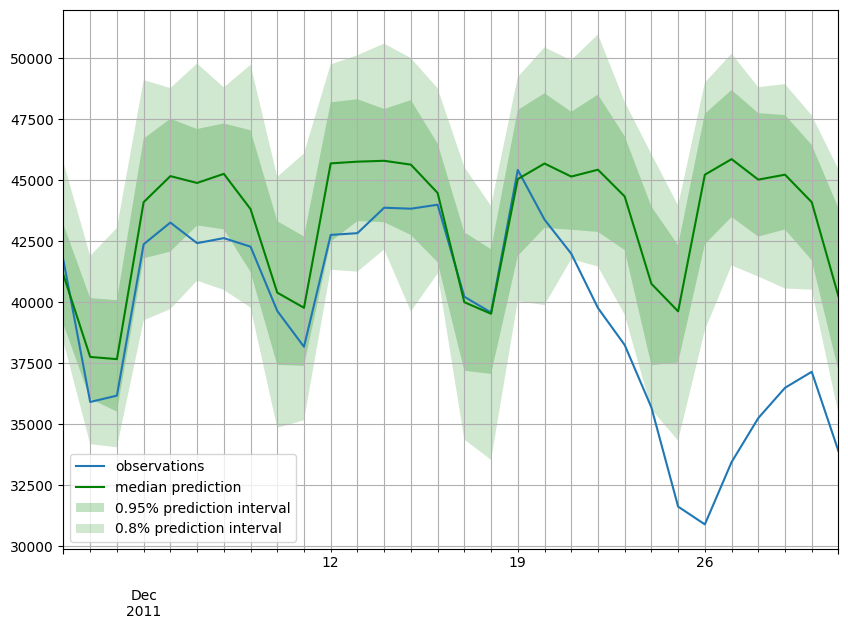

In [106]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = prediction_length
    prediction_intervals = (0.8, 0.95)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)
    forecast_entry.plot(intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="lower left")
    plt.show()


plot_prob_forecasts(tss[0], forecasts[0])

with regressors holiday + weather

In [107]:
weather3_year = df_weather[["datetime","temp"]]
weather3_year = weather3_year[(weather3_year["datetime"] >= "2009-01-01")&(weather3_year["datetime"] <= "2011-12-31")]
weather3_year["datetime"] = pd.to_datetime(weather3_year["datetime"])
weather3_year

,datetime,temp
0,2009-01-01,1.2
1,2009-01-02,2.1
2,2009-01-03,-1.7
3,2009-01-04,-2.6
4,2009-01-05,0.0
...,...,...
1090,2011-12-27,10.1
1091,2011-12-28,9.1
1092,2011-12-29,7.5
1093,2011-12-30,6.8


Merge two datasets

In [108]:
daily2

,settlement_date,tsd,is_holiday
0,2009-01-01,38528.395833,1.0
1,2009-01-02,41133.458333,0.0
2,2009-01-03,40667.791667,0.0
3,2009-01-04,41013.958333,0.0
4,2009-01-05,47322.312500,0.0
...,...,...,...
1084,2011-12-27,33447.875000,1.0
1085,2011-12-28,35252.062500,0.0
1086,2011-12-29,36492.541667,0.0
1087,2011-12-30,37148.395833,0.0


In [109]:
merged_df=pd.merge(daily2,weather3_year,left_on=daily2["settlement_date"].dt.date,right_on=weather3_year["datetime"].dt.date,how="inner")
merged_df = merged_df.drop(columns=['key_0', 'datetime'])
merged_df

,settlement_date,tsd,is_holiday,temp
0,2009-01-01,38528.395833,1.0,1.2
1,2009-01-02,41133.458333,0.0,2.1
2,2009-01-03,40667.791667,0.0,-1.7
3,2009-01-04,41013.958333,0.0,-2.6
4,2009-01-05,47322.312500,0.0,0.0
...,...,...,...,...
1084,2011-12-27,33447.875000,1.0,10.1
1085,2011-12-28,35252.062500,0.0,9.1
1086,2011-12-29,36492.541667,0.0,7.5
1087,2011-12-30,37148.395833,0.0,6.8


get the date to index

In [110]:
merged_df["settlement_date"] = pd.to_datetime(merged_df["settlement_date"])


train test split

In [111]:
merged_df.isnull().sum()

settlement_date    0
tsd                0
is_holiday         0
temp               0
dtype: int64

In [112]:
df3 = merged_df.set_index("settlement_date")
df3

,tsd,is_holiday,temp
settlement_date,,,
2009-01-01,38528.395833,1.0,1.2
2009-01-02,41133.458333,0.0,2.1
2009-01-03,40667.791667,0.0,-1.7
2009-01-04,41013.958333,0.0,-2.6
2009-01-05,47322.312500,0.0,0.0
...,...,...,...
2011-12-27,33447.875000,1.0,10.1
2011-12-28,35252.062500,0.0,9.1
2011-12-29,36492.541667,0.0,7.5


In [113]:
train_data = df3[df3.index < split_date]
test_data = df3[df3.index >= split_date]
print(train_data.shape)
print(test_data.shape)

(967, 3)
(122, 3)


In [114]:
estimator = DeepAREstimator(freq=freq,
                            context_length=context_length,
                            prediction_length=prediction_length,
                            use_feat_dynamic_real =True, # weather temp
                            num_layers=num_layers,
                            num_cells=num_cells,
                            trainer=Trainer(epochs=epochs),)

In [115]:
train_ds = ListDataset([{"start": train_data.index[0],
                              "target": train_data.tsd,
                              "feat_dynamic_real": [train_data.temp],
                              "feat_dynamic_cat": [train_data.is_holiday],
                              }],
                           freq = freq)

test_ds = ListDataset([{"start": test_data.index[0],
                              "target": test_data.tsd,
                              "feat_dynamic_real": [test_data.temp],
                              "feat_dynamic_cat": [test_data.is_holiday],
                              }],
                           freq = freq)


In [116]:
next(iter(train_ds))

{'start': Period('2009-01-01', 'D'),
 'target': array([38528.395, 41133.457, 40667.793, 41013.957, 47322.312, 49411.562,
        49179.582, 48029.957, 48309.707, 43654.688, 40793.582, 45563.168,
        46065.52 , 47131.895, 46286.312, 44067.145, 38665.957, 38297.312,
        44841.625, 45893.918, 46453.48 , 45201.145, 44568.457, 40619.812,
        39080.543, 45018.188, 46242.395, 45979.645, 46012.312, 44851.27 ,
        39894.48 , 40657.145, 46695.73 , 47376.98 , 47796.125, 47455.125,
        46680.332, 41981.375, 41477.582, 46965.73 , 46732.855, 47053.25 ,
        47734.207, 45898.02 , 41141.918, 38975.02 , 43710.25 , 44182.957,
        44380.582, 43724.688, 42576.957, 37068.125, 36191.668, 41804.543,
        42620.707, 42323.688, 42059.27 , 40588.355, 37044.918, 36288.707,
        41540.062, 42653.312, 43493.688, 44106.207, 42672.207, 36866.543,
        35977.707, 41888.105, 43485.312, 43029.625, 41885.5  , 40952.457,
        35433.668, 34907.438, 40243.855, 40206.77 , 40369.98 , 40

In [117]:
predictor_3 = estimator.train(training_data=train_ds)

100%|██████████| 50/50 [01:39<00:00,  1.99s/it, epoch=8/8, avg_epoch_loss=8.61]


In [118]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor_3,
    num_samples=100,
)


In [119]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [120]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics_3, item_metrics_3 = evaluator(iter(tss), iter(forecasts))

Running evaluation: 1it [00:00,  6.38it/s]


In [121]:
agg_metrics_3

{'MSE': 19415733.333333332,
 'abs_error': 90669.609375,
 'abs_target_sum': 1184883.75,
 'abs_target_mean': 39496.125,
 'seasonal_error': 1861.981456043956,
 'MASE': 1.6231742280190848,
 'MAPE': 0.08409237861633301,
 'sMAPE': 0.07659752368927002,
 'MSIS': 36.79608790460259,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 112265.327734375,
 'Coverage[0.1]': 0.5333333333333333,
 'QuantileLoss[0.5]': 90669.619140625,
 'Coverage[0.5]': 0.9,
 'QuantileLoss[0.9]': 25302.10820312499,
 'Coverage[0.9]': 0.9666666666666667,
 'RMSE': 4406.328781801618,
 'NRMSE': 0.1115635719150073,
 'ND': 0.07652194519082568,
 'wQuantileLoss[0.1]': 0.09474796808916908,
 'wQuantileLoss[0.5]': 0.07652195343266797,
 'wQuantileLoss[0.9]': 0.021354084907591137,
 'mean_absolute_QuantileLoss': 76079.018359375,
 'mean_wQuantileLoss': 0.06420800214314273,
 'MAE_Coverage': 0.46666666666666673,
 'OWA': nan}

In [122]:
mape_3 = round(agg_metrics_3['MAPE'],3)
smape_3 = round(agg_metrics_3['sMAPE'],3)
print(f"MAPE: {mape_3}")
print(f"sMAPE: {smape_3}")

MAPE: 0.084
sMAPE: 0.077


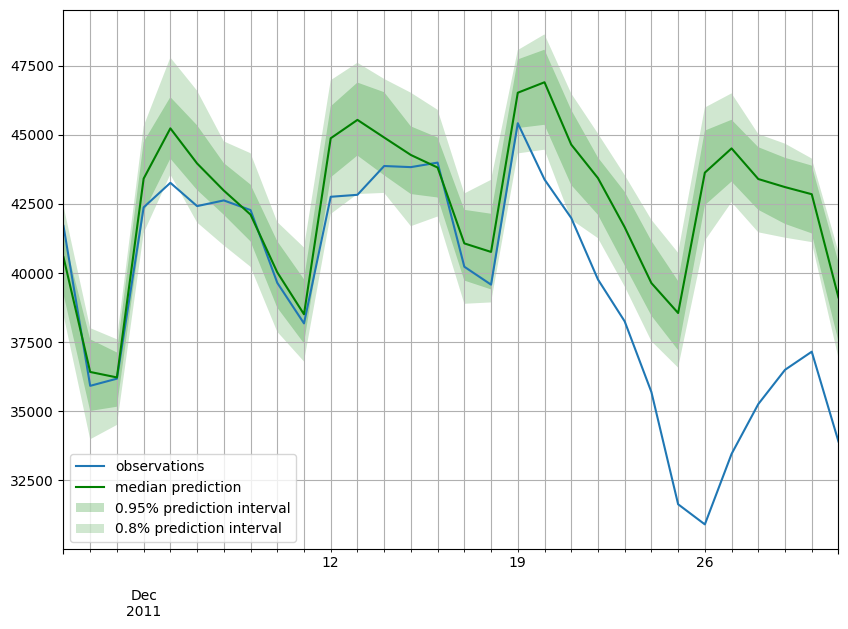

In [123]:
plot_prob_forecasts(tss[0], forecasts[0])

In [124]:
print(f"1- MAPE: {mape_1}")
print(f"1- sMAPE: {smape_1}")
print(f"2- MAPE: {mape_2}")
print(f"2- sMAPE: {smape_2}")
print(f"3- MAPE: {mape_3}")
print(f"3- sMAPE: {smape_3}")

1- MAPE: 0.083
1- sMAPE: 0.085
2- MAPE: 0.107
2- sMAPE: 0.096
3- MAPE: 0.084
3- sMAPE: 0.077
